# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [3]:
while 'model' not in os.listdir():
    os.chdir('..')

In [4]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
COMPUTER = 'gpu5.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample, SentencesDataset
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from model.utils import load_data, add_transitive

In [6]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR,)

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



In [7]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [8]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: [COL] name [VAL] microsoft powerpoint 2004 (mac) [COL] description [VAL] powerpoint 2004 offers you the powerful advanced new tools needed for fantastic presentations. whether it's for business academic or personal needs you'll design dynamic and visual presentations that stand out and get noticed. [COL] manufacturer [VAL] microsoft [COL] price [VAL] 229.99
Entity2: [COL] name [VAL] microsoft office outlook 2007 [COL] description [VAL] key features: manages time and info works with sharepoint enhanced search one-click functionality create internet calendars enhanced security ... [COL] manufacturer [VAL]  [COL] price [VAL] 109.95
Label: 0

Sample 1:
Entity1: [COL] name [VAL] peachtree by sage premium accounting 2007 - accountants' edition [COL] description [VAL] peachtree premium accounting 2007 accountants' edition is the powerful multi-user ready accounting solution accountants need to service their peachtree clients more effectively and efficiently. create open mod

In [9]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train[i]) for i in range(len(X_train_ids))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid[i]) for i in range(len(X_valid_ids))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test[i]) for i in range(len(X_test_ids))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [10]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 200
CLASSIFIER_DROPOUT = None
threshold = 0.65

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [11]:
final_table_exports = ""
results = {}

In [12]:
def show_results():
    global results
    roc_curve_fig, roc_curve_ax = plt.subplots(figsize=(10, 10))
    acc_threshold_fig, acc_threshold_ax = plt.subplots(figsize=(10, 10))
    prec_recall_threshold_fig, prec_recall_threshold_ax = plt.subplots(figsize=(10, 10))
    f1_threshold_fig, f1_threshold_ax = plt.subplots(figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (model_name, (logits, train_time)) in enumerate(results.items()):
        y_pred = logits > threshold
        y_true = y_test
        print(f'Model: {model_name}')
        print(classification_report(y_true, y_pred))
        print(f'AUC: {roc_auc_score(y_true, logits)}')
        print(f'Train time: {train_time}')
        print()
        fpr, tpr, _ = roc_curve(y_true, logits)
        roc_curve_ax.plot(fpr, tpr, label=model_name)

        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        precions = []
        recalls = []
        f1_scores = []
        for th in thresholds:
            y_pred = logits > th
            accuracies.append(np.mean(y_pred == y_true))
            precions.append(np.sum(y_pred * y_true) / np.sum(y_pred) if np.sum(y_pred) != 0 else 1)
            recalls.append(np.sum(y_pred * y_true) / np.sum(y_true))
            f1_scores.append(2 * precions[-1] * recalls[-1] / (precions[-1] + recalls[-1]) if precions[-1] + recalls[-1] != 0 else 0)
        acc_threshold_ax.plot(thresholds, accuracies, label=model_name)
        prec_recall_threshold_ax.plot(thresholds, precions, label=model_name + " precision", color=colors[i])
        prec_recall_threshold_ax.plot(thresholds, recalls, label=model_name + " recall", color=colors[i], linestyle='--')
        f1_threshold_ax.plot(thresholds, f1_scores, label=model_name)


    
    roc_curve_ax.plot([0, 1], [0, 1], 'k--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('ROC curve')
    roc_curve_ax.legend()

    acc_threshold_ax.set_xlabel('Threshold')
    acc_threshold_ax.set_ylabel('Accuracy')
    acc_threshold_ax.set_title('Accuracy vs Threshold')
    acc_threshold_ax.legend()

    prec_recall_threshold_ax.set_xlabel('Threshold')
    prec_recall_threshold_ax.set_ylabel('Precision/Recall')
    prec_recall_threshold_ax.set_title('Precision/Recall vs Threshold')
    prec_recall_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    prec_recall_threshold_ax.legend()

    f1_threshold_ax.set_xlabel('Threshold')
    f1_threshold_ax.set_ylabel('F1 Score')
    f1_threshold_ax.set_title('F1 Score vs Threshold')
    f1_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    f1_threshold_ax.legend()

    plt.show()

### MS Marco MiniLM l-12

- Architecture: MiniLM-L-12
- Parameters: ~33 million
- Layers: 12 Transformer layers
- Hidden Size: 384
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L-2-v2)
- MS MARCO Passage Retrieval is a large dataset with real user queries from Bing search engine with annotated relevant text passages.

In [13]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-12-v2'

In [14]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [15]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.8043456595347291 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.8548561692156023 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.8735621709049911 - Steps -1


In [16]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       708
           1       0.82      0.87      0.84       128

    accuracy                           0.95       836
   macro avg       0.90      0.92      0.91       836
weighted avg       0.95      0.95      0.95       836



In [17]:
# Exemple of prediction
print(f'Prediction: {y_pred[0]}')
print(f'Label: {y_test[0]}')
print(f'Sample 1: {X1_test[0]}')
print(f'Sample 2: {X2_test[0]}')

Prediction: False
Label: 0
Sample 1: [COL] name [VAL] adobe photoshop cs3 extended [COL] description [VAL] ideal for film video and multimedia professionals and graphic and web designers using 3d and motion as well as professionals in engineering and science adobe photoshop cs3 extended software delivers everything in photoshop cs3 and more. render and incorporate 3d images into your 2d composites. stop time with easy editing of motion graphics on video layers. and probe your images with measurement analysis and visualization tools. the professional standard now comes in two versions& 151;photoshop cs3 and photoshop cs3 extended with additional features and enhancements for specialized image professionals. the clone stamp and healing brush tools now feature an overlay preview of the source areas. the loupe tool in adobe bridge cs3 lets you easily zoom into the fine detail of any image. zoomify export allows you to efficiently display even the highest resolution imagery over low bandwid

In [18]:
e1, e2 = X1_test[np.nonzero(y_test)[0][0]], X2_test[np.nonzero(y_test)[0][0]]
print('Entity 1:', e1)
print('Entity 2:', e2)
print(f'Label: {y_test[np.nonzero(y_test)[0][0]]}')
print(f'Prediction: {y_pred[np.nonzero(y_test)[0][0]]}')

Entity 1: [COL] name [VAL] calculation skills v1 add & sub - basic - core learning [COL] description [VAL] this four volume series builds fundamental calculation competence with four core arithmetic operations. two volumes provide calculation practice with addition and subtraction at a basic and advanced level; the other two volumes provide calculation practice with multiplication and division at a basic and advanced level. volume 1 features helpful calculation information: how to add addition table how to subtract subtraction table take away from 10 or 9 table money and decimals change from $1.00 table the program provides three timed drills basic addition drill basic subtraction drill making change from $1.00 drillsystem requirements: windows 98/me/2000/xp pentium ii 400 mhz + 96 mb ram + 25 mb hard disk space cd-rom drive vga display 16-bit color with 800x600 resolutionformat: win 98 me 2000 xp [COL] manufacturer [VAL] sos aggregation company [COL] price [VAL] 0.0
Entity 2: [COL] na

### STS RoBERTa-base

- Architecture: RoBERTa-base
- Parameters: ~125 million
- Layers: 12 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-roberta-base)
- Train to predict the similarity between two sentences

In [19]:
MODEL_NAME = 'cross-encoder/stsb-roberta-base'

In [20]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [21]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.8754647510312379 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.9144295752098445 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.90584176186659 - Steps -1


In [22]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       708
           1       0.85      0.86      0.86       128

    accuracy                           0.96       836
   macro avg       0.91      0.92      0.91       836
weighted avg       0.96      0.96      0.96       836



### STS DistilRoBERTa-base

- Architecture: DistilRoBERTa-base
- Parameters: ~82 million
- Layers: 6 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-distilroberta-base)
- Train to predict the similarity between two sentences

In [23]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'

In [24]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [25]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 - Score 0.8270749307340374 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 - Score 0.8692293380916579 - Steps -1


Iteration:   0%|          | 0/370 [00:00<?, ?it/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 - Score 0.8849043213377311 - Steps -1


In [26]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       708
           1       0.84      0.88      0.86       128

    accuracy                           0.96       836
   macro avg       0.91      0.92      0.92       836
weighted avg       0.96      0.96      0.96       836



In [27]:
def add_transitivity(X1_test, X2_test, y_pred):
    # If A is similar to B and B is similar to C, then A is similar to C (y_pred = 1)
    for i, e1 in enumerate(X1_test):
        # Find all entities similar to e1
        similar_entities = [e2 for j, e2 in enumerate(X2_test) if y_pred[j] == 1]

Model: cross-encoder/ms-marco-MiniLM-L-12-v2
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       708
           1       0.82      0.87      0.84       128

    accuracy                           0.95       836
   macro avg       0.90      0.92      0.91       836
weighted avg       0.95      0.95      0.95       836

AUC: 0.9757349046610169
Train time: 144.71371245384216

Model: cross-encoder/stsb-roberta-base
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       708
           1       0.85      0.86      0.86       128

    accuracy                           0.96       836
   macro avg       0.91      0.92      0.91       836
weighted avg       0.96      0.96      0.96       836

AUC: 0.984717072740113
Train time: 403.0950725078583

Model: cross-encoder/stsb-distilroberta-base
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       70

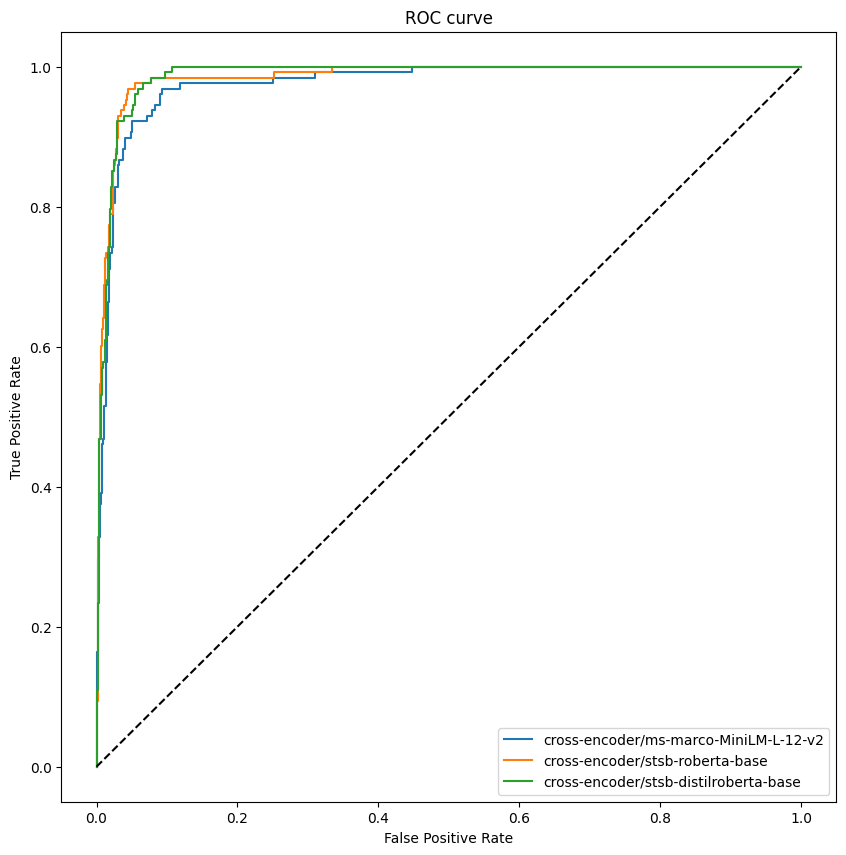

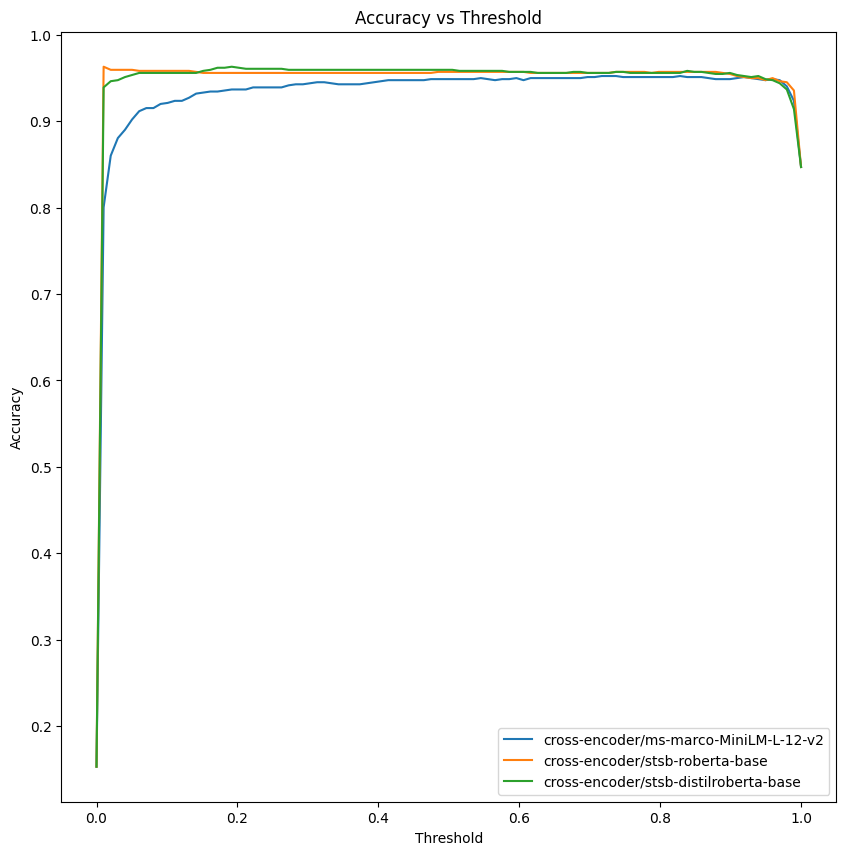

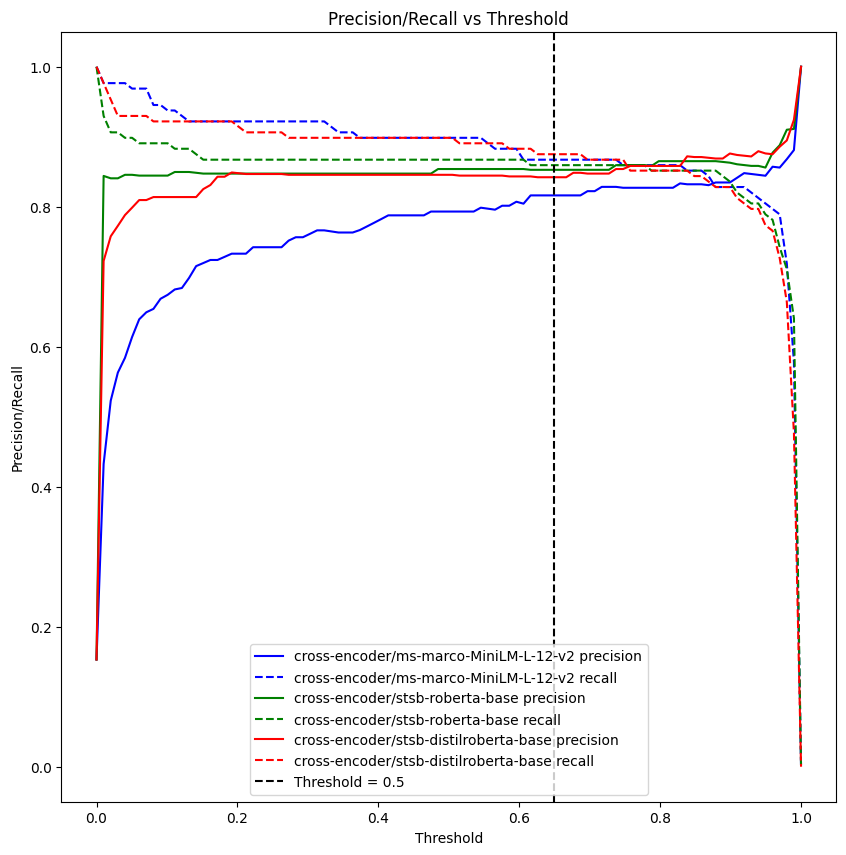

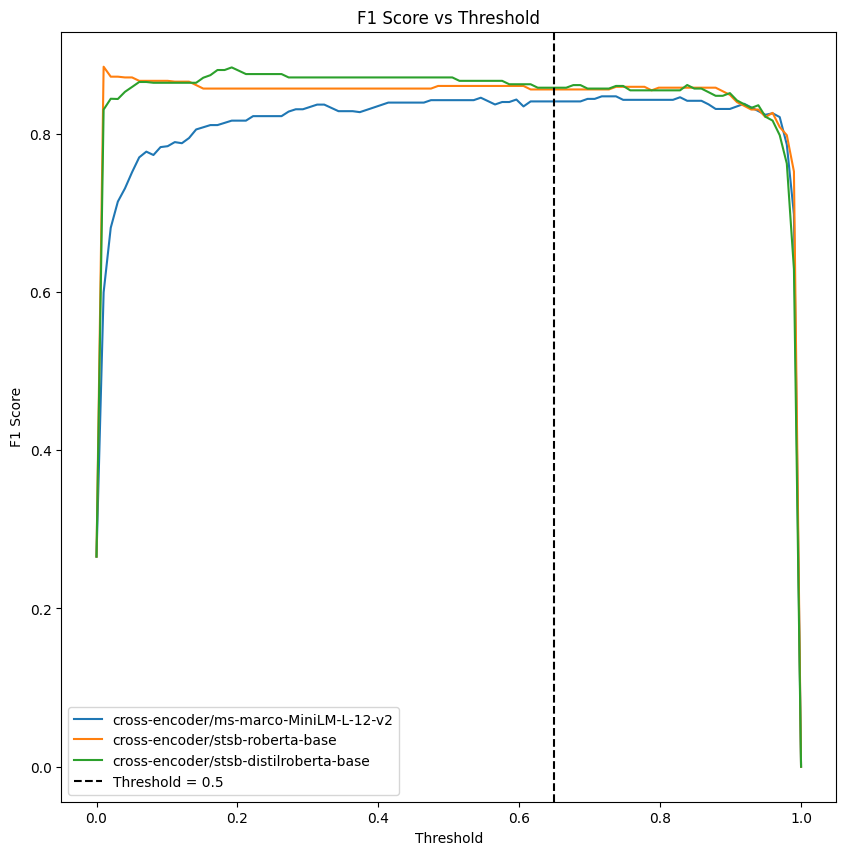

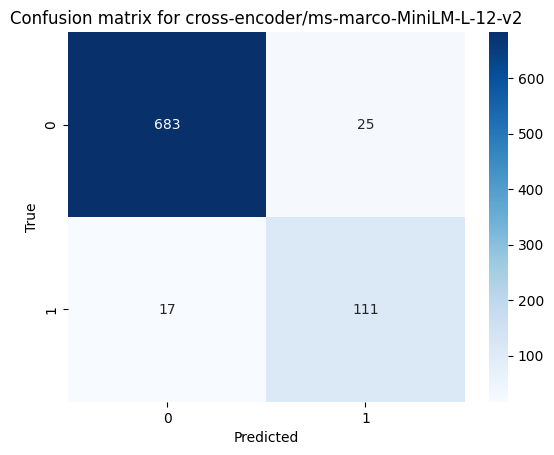

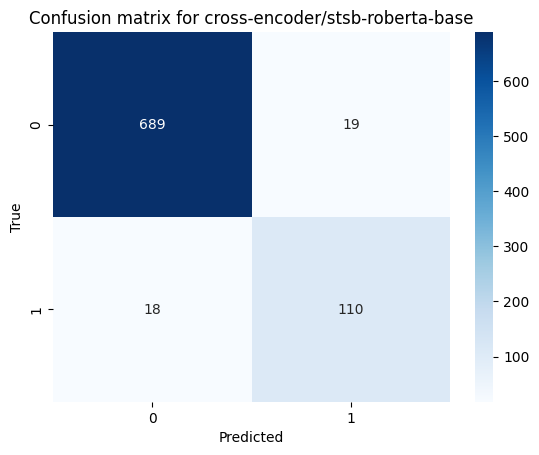

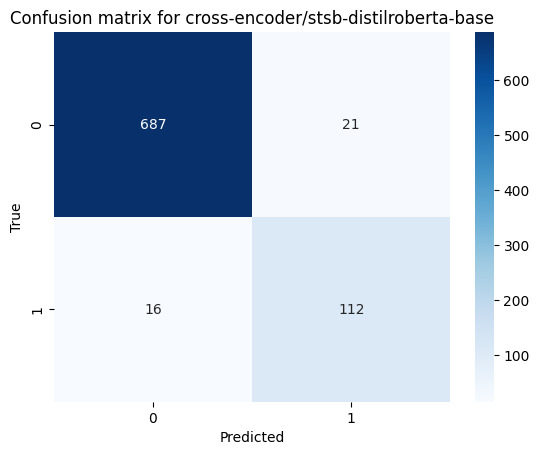

In [28]:
show_results()

In [29]:
%matplotlib inline

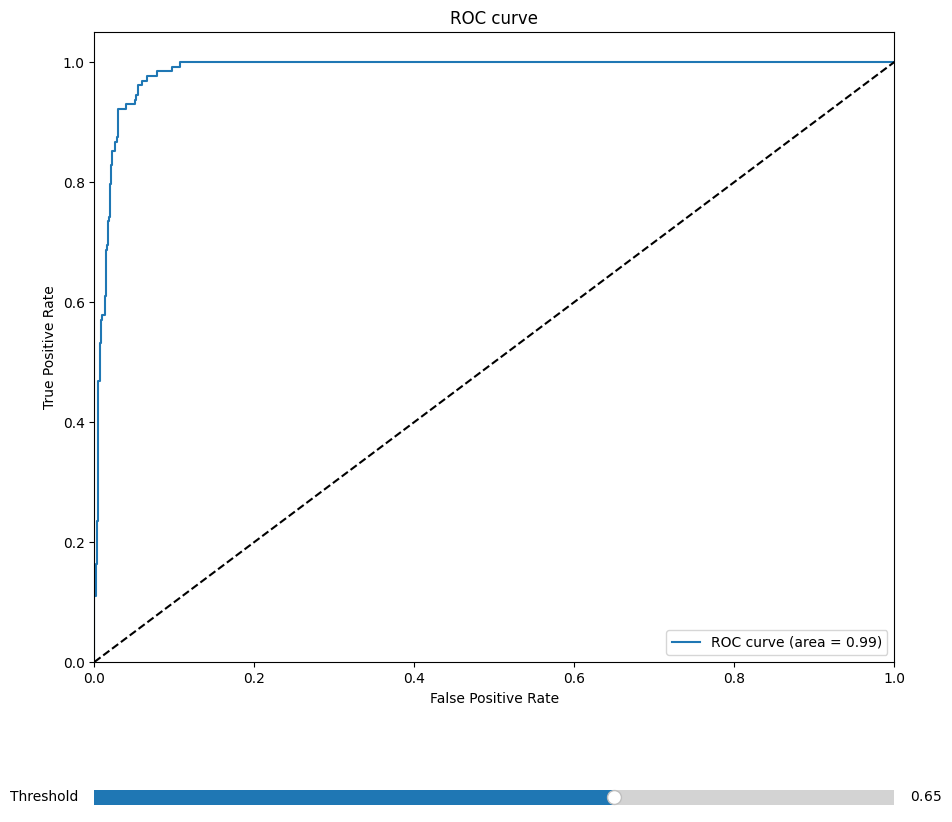

In [30]:
from matplotlib.widgets import Slider

fig, ax = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(left=0.1, bottom=0.25)

fpr, tpr, thresholds = roc_curve(y_test, logits)
roc_auc = roc_auc_score(y_test, logits)
line, = ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc="lower right")

ax_threshold = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
slider_threshold = Slider(ax_threshold, 'Threshold', 0.0, 1.0, valinit=threshold, valstep=0.01)

def update(val):
    threshold = slider_threshold.val
    y_pred = logits > threshold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    line.set_ydata(tpr)
    line.set_xdata(fpr)
    fig.canvas.draw_idle()

slider_threshold.on_changed(update)

plt.show()